In [1]:
# import libraries

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np

import time

# Pandas warning messages (optional)
pd.options.mode.chained_assignment = None  #default='warn'

# Plot options
import matplotlib.pyplot as plt
import seaborn as sns
sns.palplot(sns.color_palette('deep'))
sns.set_style("whitegrid")
%matplotlib inline

In [23]:
df_cleaned = pd.read_csv('data/listings_cleaned.csv', low_memory=False)
df_cleaned.head()

,id,property_type,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,longitude,latitude,number_of_reviews,availability_365,review_scores_rating,minimum_nights,listing_url,price_per_person,region
0,2265,House,Entire home/apt,225.0,4,2.0,2.0,t,-97.71398,30.27750,24,0,93.0,30,https://www.airbnb.com/rooms/2265,56.250000,Central
1,5245,House,Private room,100.0,2,1.0,1.0,t,-97.71379,30.27577,9,0,91.0,30,https://www.airbnb.com/rooms/5245,50.000000,Central
2,5456,Guesthouse,Entire home/apt,95.0,3,1.0,1.0,t,-97.73448,30.26112,529,334,97.0,2,https://www.airbnb.com/rooms/5456,31.666667,Central
3,5769,House,Private room,40.0,2,1.0,1.0,t,-97.78422,30.45697,257,14,98.0,1,https://www.airbnb.com/rooms/5769,20.000000,North
4,6413,Guesthouse,Entire home/apt,99.0,2,1.0,1.0,t,-97.73726,30.24829,112,0,99.0,3,https://www.airbnb.com/rooms/6413,49.500000,Central


In [45]:
features_list = ['property_type', 'room_type', 'bathrooms', 'bedrooms', 'host_is_superhost',  'region',
                 'review_scores_rating']#'accommodates', , 'number_of_reviews']

# Create features and price DFs for sklearn inputs
features = df_cleaned[features_list]   # 'X'
y = df_cleaned['price']           # 'y'

In [46]:
# Create dummy variables for 'room type', 'superhost' and 'region'
features = pd.get_dummies(features)
features.head()

,bathrooms,bedrooms,review_scores_rating,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,...,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
0,2.0,2.0,93.0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
1,1.0,1.0,91.0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0
2,1.0,1.0,97.0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,1.0,1.0,98.0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,1.0,1.0,99.0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [48]:
from sklearn.decomposition import PCA

# Set up PCA and the X vector for diminsionality reduction
pca = PCA()
df_X = features[['bathrooms', 'bedrooms', 'review_scores_rating']]#,, 'accommodates', 'number_of_reviews']]

# Apply PCA to the wine dataset X vector
transformed_X = pca.fit_transform(df_X)

# Look at the percentage of variance explained by the different components
print(pca.explained_variance_ratio_)

[0.95163954 0.04406509 0.00429537]


In [51]:
# Scale the quantitative features
# Note: using RobustScaler resulted in similar r2 results
scaler = MinMaxScaler()
numerical = ['bathrooms', 'bedrooms', 'review_scores_rating']#,, 'accommodates', 'number_of_reviews']
features_scaled = features.copy()
features_scaled[numerical] = scaler.fit_transform(features_scaled[numerical])

In [52]:
features_scaled.head()

,bathrooms,bedrooms,review_scores_rating,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,...,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
0,0.200000,0.142857,0.9125,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
1,0.066667,0.071429,0.8875,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0
2,0.066667,0.071429,0.9625,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0.066667,0.071429,0.9750,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,0.066667,0.071429,0.9875,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [53]:
#features_scaled.to_csv('data/listings_scaled.csv')

### Modeling:

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, 
                                                    y, 
                                                    test_size = .30, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Test set has {} samples.".format(X_test.shape[0]))

Training set has 8146 samples.
Test set has 3492 samples.


In [57]:
models = [SVR(kernel='linear'),
          DecisionTreeRegressor(max_depth= 8, min_samples_leaf= 5),
          #LinearRegression(),
          KNeighborsRegressor(n_neighbors=7),
          RandomForestRegressor(n_estimators=100)]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]
    results[name] = r2_score(y_test, y_test_preds)
    
print(results)

{'SVR': 0.09645124460541099, 'DecisionTreeRegressor': 0.4025579508262703, 'KNeighborsRegressor': 0.40592506136475104, 'RandomForestRegressor': 0.3875980945764784}


In [58]:
# Training Decision Tree Classifier Model
modelDTR = DecisionTreeRegressor()

modelDTR.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [59]:
X_test

,bathrooms,bedrooms,review_scores_rating,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,...,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
7669,0.266667,0.214286,0.97500,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
6008,0.266667,0.357143,0.98750,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
9924,0.066667,0.071429,0.94967,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
119,0.466667,0.357143,0.96250,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
914,0.066667,0.142857,0.98750,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800,0.066667,0.071429,1.00000,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
4202,0.066667,0.071429,0.95000,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
59,0.066667,0.071429,0.97500,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
8206,0.066667,0.000000,1.00000,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [60]:
y_test

7669    651.0
6008    249.0
9924    499.0
119     995.0
914     198.0
        ...  
3800     50.0
4202    500.0
59      119.0
8206     96.0
4639     70.0
Name: price, Length: 3492, dtype: float64

In [61]:
modelDTR.score(X_test, y_test)

0.22928931897510252

In [62]:
# Accuracy score for Decision Tree
y_pred = modelDTR.predict(X_test)
cross_val_score(modelDTR, features_scaled, y, cv=10)
#print('Decision Tree Regressor accuracy: {:.2f}'.format()))

array([-0.15418836, -0.00507422,  0.2216526 ,  0.03552089,  0.00483755,
       -0.03258673,  0.31626284,  0.51827195,  0.10804084, -0.25888572])

In [63]:
# Using GridSearchCV on DecisionTreeClassifier
#create a dictionary of all values we want to test
param_dist = {"max_depth": np.arange(1, 21),
              #"max_features": randint(1, 9),
              "min_samples_leaf": [1, 5, 10, 20, 50, 100],
              #"criterion": ["gini", "entropy"]
             }
#use gridsearch to test all values
tree_cv = GridSearchCV(DecisionTreeRegressor(), param_dist, cv=5)
#fit model to data
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                     

In [64]:
print(tree_cv.best_params_)
print(cross_val_score(modelDTR, features_scaled, y, cv=10))

{'max_depth': 11, 'min_samples_leaf': 10}
[-0.15033101  0.00789427  0.22432809  0.04416824 -0.00300371 -0.02416546
  0.30619586  0.48959985  0.16515154 -0.26913004]


In [65]:
modelDTR = DecisionTreeRegressor(max_depth= 11, min_samples_leaf= 10)
modelDTR.fit(X_train, y_train)
y_test_preds = modelDTR.predict(X_test)
print(y_test_preds)
r2_score(y_test, y_test_preds)

[425.05       424.52941176 432.28571429 ... 128.56020942 111.06849315
  55.        ]


0.3983977040350988

In [66]:
knn = KNeighborsRegressor(algorithm='brute')
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
knn_mse = mean_squared_error(predictions, y_test)
knn_mse

101855.19087915235

In [67]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [68]:
xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:   44.0s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_chi

In [69]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.0 minutes

Training MSE: 68601.2157
Validation MSE: 89753.8633

Training r2: 0.6354
Validation r2: 0.4286


Text(0.5, 1.0, 'Comparison of Regression Models')

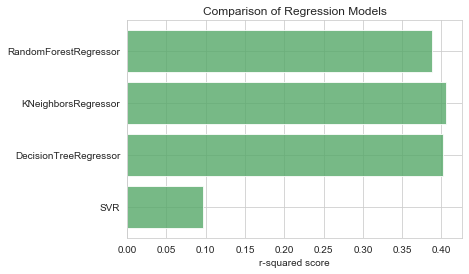

In [70]:
fig, ax = plt.subplots()

ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('r-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')